In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from models import ConvNet
from utils import train_model

#### Loading data


In [2]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Text(0.5, 1.0, 'Label: 4')

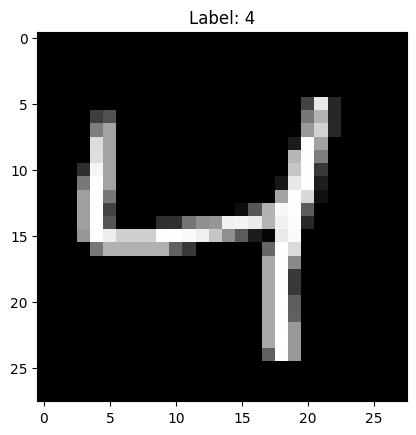

In [3]:
# visualize a sample of the data to test if it is loaded correctly
sample_idx = 2
plt.imshow(train_dataset.data[sample_idx], cmap='gray')
plt.title(f'Label: {train_dataset.targets[sample_idx]}')

## Without active learning

In [53]:
label_budget = 1000  # number of labels to use for training (with or without active learning)

In [59]:
# using the DataLoader to load the data in batches
batch_size = 32
random_pool_idx = np.random.choice(len(train_dataset), label_budget, replace=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True, sampler=torch.utils.data.SubsetRandomSampler(random_pool_idx))
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Training

In [60]:
# Define the model as simple CNN
model = ConvNet()
train_model(model=model, train_loader=train_loader)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


#### Evaluation

In [61]:
# Evaluate the model
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')


Accuracy of the model on the 10000 test images: 81.68%


## Active Learning

Now doing image classification on MNIST but we start without labels. 
We start with random selection baseline.

In [62]:
def active_learning_loop(train_dataset, initial_pool_size, n_samples, n_iterations, batch_size):
    # Initialize the pool as random selection of X points from the training data
    pool_idx = np.random.choice(len(train_dataset), initial_pool_size, replace=False)
    
    for iteration in range(n_iterations):
        print(f"Active Learning Iteration {iteration + 1}/{n_iterations}")
        
        # Define loader for the pool data
        pool_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                                 sampler=torch.utils.data.SubsetRandomSampler(pool_idx))
        
        # Define loader for the unlabeled data
        unlabeled = list(set(range(len(train_dataset))) - set(pool_idx))
        unlabeled_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                                      sampler=torch.utils.data.SubsetRandomSampler(unlabeled))
        
        # Train the model with the pool
        model = ConvNet()
        train_model(model=model, train_loader=pool_loader)
        
        # Calculate uncertainties for unlabeled data
        model.eval()
        uncertainties = []
        with torch.no_grad():
            for images, _ in unlabeled_loader:
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                entropy = -torch.sum(probs * torch.log(probs), dim=1)
                uncertainties.append(entropy)
        
        uncertainties = torch.cat(uncertainties)
        
        # Select the indices of the most uncertain samples from the unlabeled data
        most_uncertain_idx = np.argsort(uncertainties.numpy())[-n_samples:]
        
        # Get the indices of the selected samples in the original dataset
        most_uncertain_idx = [unlabeled[i] for i in most_uncertain_idx]
        
        # Add the selected samples to the pool
        pool_idx = np.concatenate((pool_idx, most_uncertain_idx))
        
        print(f"Pool size: {len(pool_idx)}")
        print("--------------------")
    
    return model, pool_idx

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Usage
initial_pool_size = 500
n_samples = 25
n_iterations = (label_budget - initial_pool_size) // n_samples
batch_size = 32

final_model, final_pool_idx = active_learning_loop(train_dataset, initial_pool_size, n_samples, n_iterations, batch_size)

Active Learning Iteration 1/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 525
--------------------
Active Learning Iteration 2/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 550
--------------------
Active Learning Iteration 3/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 575
--------------------
Active Learning Iteration 4/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 600
--------------------
Active Learning Iteration 5/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 625
--------------------
Active Learning Iteration 6/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 650
--------------------
Active Learning Iteration 7/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 675
--------------------
Active Learning Iteration 8/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Pool size: 700
--------------------
Active Learning Iteration 9/20
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epo

In [63]:
# evaluate the model
final_model.eval()
train_acc = evaluate_model(final_model, train_loader)
test_acc = evaluate_model(final_model, test_loader)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")


Train accuracy: 0.8649193548387096
Test accuracy: 0.8839


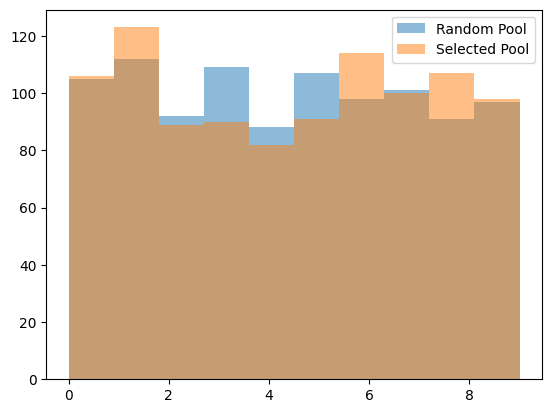

In [65]:
# compare class distribution of the random pool and the final pool
_, random_pool_labels = zip(*[train_dataset[i] for i in random_pool_idx])
_, final_pool_labels = zip(*[train_dataset[i] for i in final_pool_idx])

plt.hist(random_pool_labels, bins=10, alpha=0.5, label='Random Pool')
plt.hist(final_pool_labels, bins=10, alpha=0.5, label='Selected Pool')
plt.legend()
plt.show()